In [1]:
#Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#AIF360 Dataset Classes 
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset

#AIF360 Metrics Classes  
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from aif360.metrics import ClassificationMetric

#AIF360 Algorithms 
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing
# AI360 Explainers
from aif360.explainers import MetricTextExplainer

#Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split

#Tensorflow -- install version before 2.0
import tensorflow as tf 

#For Markdown
from IPython.display import Markdown, display

#Helper Functions
from src.classifier_functions import *
from src.dataset_functions import *

//anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
salary_list = [100000, 125000, 150000, 175000, 200000, 225000, 250000]

In [3]:
datasets = create_multiple_datasets(create_binary_dataset_salary, salary_list)

In [4]:
means, impact = get_dataset_metrics_list(datasets)


In [75]:
means

[-0.14185487472152958,
 -0.16401331241161143,
 -0.15509419201537045,
 -0.14209465548393385,
 -0.12145545439959105,
 -0.09054074487034675,
 -0.06845718960460986]

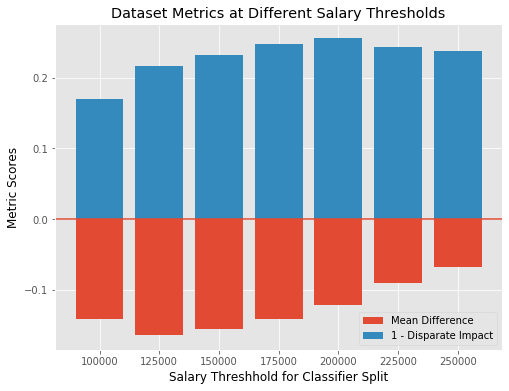

In [6]:
fig, ax = plt.subplots(figsize = (8,6))
x_axis = range(len(salary_list))

ax.bar(x_axis, means, label='Mean Difference' )
ax.bar(x_axis, impact, label='1 - Disparate Impact')
ax.axhline(0)
ax.set_xticks(x_axis)
ax.set_xticklabels(salary_list)
ax.set_title('Dataset Metrics at Different Salary Thresholds')
ax.set_xlabel('Salary Threshhold for Classifier Split', color='black')
ax.set_ylabel('Metric Scores', color='black')
ax.legend()
plt.savefig('images/model_metrics')

In [9]:
x_axis

range(0, 7)

In [10]:
salary_list

[100000, 125000, 150000, 175000, 200000, 225000, 250000]

In [11]:
def create_split_lists(dataset_list):
    #Create Train, Validation, Test Sets
    data_train_list =[]
    data_val_list = []
    data_test_list =[]
    for dataset in dataset_list:
        data_train, data_vt = dataset.split([0.7], shuffle=True)
        data_val, data_test = data_vt.split([0.5], shuffle=True)

        data_train_list.append(data_train)
        data_val_list.append(data_val) 
        data_test_list.append(data_test) 
    return data_train_list, data_val_list, data_test_list 
    


In [12]:
train_list, val_list, test_list = create_split_lists(datasets)

In [13]:
def get_predictions(estimator, train_list, test_list):
    pred_list = []
    for train_, test_ in zip(train_list, test_list):
        X_train = train_.features
        y_train = train_.labels.ravel()
        X_test = test_.features  
        model = estimator
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        preds = test_.copy()
        preds.labels = y_pred.ravel()
        pred_list.append(preds)
    return pred_list

    

In [14]:
pred_list = get_predictions(RandomForestClassifier(n_estimators=500, max_depth=5, ), 
                train_list, val_list)

In [15]:
val_list[0].features

array([[ 0.,  1.,  6., ...,  1.,  0.,  0.],
       [ 1.,  1.,  2., ...,  1.,  0.,  0.],
       [ 0.,  0.,  4., ...,  0.,  0.,  1.],
       ...,
       [ 1.,  1.,  5., ...,  1.,  0.,  0.],
       [ 1.,  0.,  3., ...,  0.,  0.,  0.],
       [ 0.,  1., 11., ...,  0.,  0.,  0.]])

In [16]:
#get_classifier_metrics()

In [17]:
def show_classifier_metrics(test_list, prediction_list):
    privileged_groups= [{'sex':1}]
    unprivileged_groups= [{'sex': 0}]
    
    
    counter = 1 
    for test_, pred_ in zip(test_list, prediction_list):
        
        display(Markdown("#### Model {}  dataset metrics".format(counter)))
        

        model_metric = ClassificationMetric(test_, pred_, 
                            unprivileged_groups=unprivileged_groups, 
                            privileged_groups=privileged_groups)

        ex_model_metric= MetricTextExplainer(model_metric)
        print(ex_model_metric.average_odds_difference())

        print('Difference in Recall between Unprivileged and Privileged: {:.3f}'
          .format(model_metric.equal_opportunity_difference()))

        print('Difference in Precision between Unprivileged and Privileged: {:.3f}.'
            .format(model_metric.precision(privileged=False)- model_metric.precision(privileged=True)))
        counter +=1

In [18]:
show_classifier_metrics(val_list, pred_list)



#### Model 1  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.17104099698361505
Difference in Recall between Unprivileged and Privileged: -0.068
Difference in Precision between Unprivileged and Privileged: -0.018.


#### Model 2  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.20136195782660893
Difference in Recall between Unprivileged and Privileged: -0.002
Difference in Precision between Unprivileged and Privileged: 0.028.


#### Model 3  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.17513417250035818
Difference in Recall between Unprivileged and Privileged: -0.004
Difference in Precision between Unprivileged and Privileged: 0.030.


#### Model 4  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.15502925536176018
Difference in Recall between Unprivileged and Privileged: -0.004
Difference in Precision between Unprivileged and Privileged: -0.032.


#### Model 5  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.07834688412686255
Difference in Recall between Unprivileged and Privileged: -0.038
Difference in Precision between Unprivileged and Privileged: 0.012.


#### Model 6  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.07953564676691804
Difference in Recall between Unprivileged and Privileged: -0.064
Difference in Precision between Unprivileged and Privileged: -0.034.


#### Model 7  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.01679605583687093
Difference in Recall between Unprivileged and Privileged: -0.036
Difference in Precision between Unprivileged and Privileged: -0.667.


In [23]:
def get_classifier_metrics(test_list, prediction_list):
    privileged_groups= [{'sex':1}]
    unprivileged_groups= [{'sex': 0}]
    acc_list = []
    bal_acc_list = []
    avg_odds_list=[]
    recall_diff_list = []
    precision_diff_list = []
    for test_, pred_ in zip(test_list, prediction_list):
        model_metric = ClassificationMetric(test_, pred_, 
                            unprivileged_groups=unprivileged_groups, 
                            privileged_groups=privileged_groups)
        
        acc_list.append(1 - (model_metric.accuracy().round(3)))
        bal_acc_list.append(1- ((model_metric.true_positive_rate()+ model_metric.true_negative_rate(privileged=True))/2).round(3))
        avg_odds_list.append(model_metric.average_odds_difference().round(3))
        recall_diff_list.append(model_metric.equal_opportunity_difference().round(3))
        precision_diff_list.append((model_metric.precision(privileged=False)- model_metric.precision(privileged=True)).round(3))  
    return acc_list, bal_acc_list, avg_odds_list, recall_diff_list, precision_diff_list

In [24]:
classifier_stats = get_classifier_metrics(val_list, pred_list)

In [25]:
classifier_stats

([0.11399999999999999,
  0.15300000000000002,
  0.23199999999999998,
  0.30900000000000005,
  0.34299999999999997,
  0.30900000000000005,
  0.267],
 [0.28800000000000003, 0.344, 0.365, 0.394, 0.386, 0.389, 0.491],
 [-0.171, -0.201, -0.175, -0.155, -0.078, -0.08, -0.017],
 [-0.068, -0.002, -0.004, -0.004, -0.038, -0.064, -0.036],
 [-0.018, 0.028, 0.03, -0.032, 0.012, -0.034, -0.667])

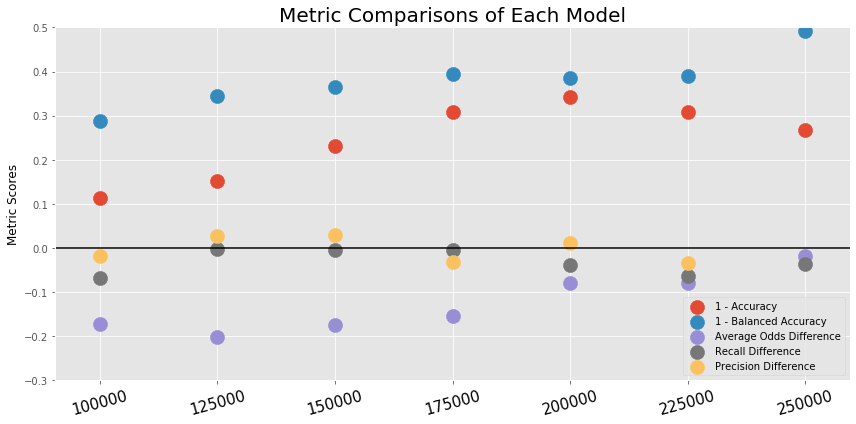

In [29]:
fig, ax = plt.subplots(figsize = (12,6))
x_axis = range(len(classifier_stats[0]))





ax.scatter(x_axis, classifier_stats[0], label='1 - Accuracy', s=200 )
ax.scatter(x_axis, classifier_stats[1], label='1 - Balanced Accuracy', s=200 )
ax.scatter(x_axis, classifier_stats[2], label='Average Odds Difference', s=200 )
ax.scatter(x_axis, classifier_stats[3], label='Recall Difference', s=200 )
ax.scatter(x_axis, classifier_stats[4], label='Precision Difference', s=200 )

ax.axhline(0, color='black')
ax.set_xticks(x_axis)
ax.set_xticklabels(salary_list, rotation=15, color='black', size=15 )
# ax.set_title('Dataset Metrics at Different Salary Threshold')
# ax.set_xlabel('Salary Threshhold for Classifier Split')

ax.legend(loc='upper right')
ax.set_ylim(-.3, .5)
ax.set_ylabel('Metric Scores', color = 'black')
ax.set_title('Metric Comparisons of Each Model',size=20)
plt.tight_layout()

ax.legend()
plt.savefig('images/classifier_metrics')

In [89]:
test_mean, test_di = get_dataset_metrics_list(val_list)

In [90]:
pred_mean, pred_di = get_dataset_metrics_list(pred_list)

In [91]:
train_mean, train_di = get_dataset_metrics_list(train_list)

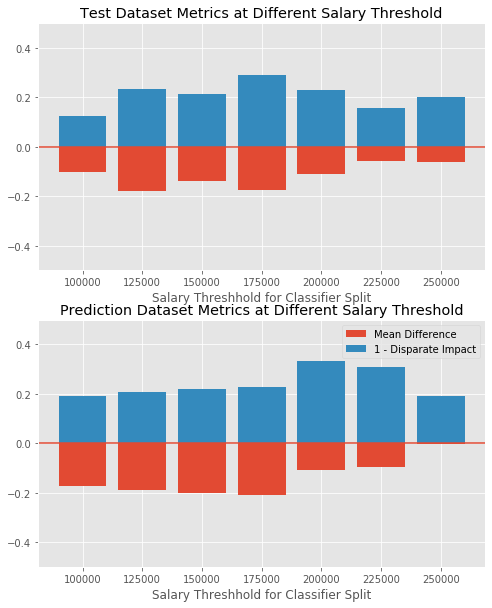

In [94]:
fig, axes = plt.subplots(2,1, figsize = (8,10))
x_axis = range(len(salary_list))

axes[0].bar(x_axis, test_mean, label='Mean Difference' )
axes[0].bar(x_axis, test_di, label='1 - Disparate Impact')
axes[0].axhline(0)
axes[0].set_xticks(x_axis)
axes[0].set_xticklabels(salary_list)
axes[0].set_title('Test Dataset Metrics at Different Salary Threshold')
axes[0].set_xlabel('Salary Threshhold for Classifier Split')
axes[0].set_ylim(-.5, .5)

axes[1].bar(x_axis, pred_mean, label='Mean Difference' )
axes[1].bar(x_axis, pred_di, label='1 - Disparate Impact')
axes[1].axhline(0)
axes[1].set_xticks(x_axis)
axes[1].set_xticklabels(salary_list)
axes[1].set_title('Prediction Dataset Metrics at Different Salary Threshold')
axes[1].set_xlabel('Salary Threshhold for Classifier Split')
axes[1].set_ylim(-.5, .5)

plt.legend()
plt.savefig('images/side_by_side_metrics')